# TODO list

- [ x] Implement simple mandelbrot routine and simple visual
- [ ]  Add a recursive zoom routine
    - [ ] Simple algorithm: split region in k squares and zoom into the one with closest to 50/50 stable
    - [ ] Find a way to compute fractal dimension for each region. Zoom on `least integer' dimension
- [ ] Add option to change exponent, e.g. $f(z) = z^n + c$
- [ ] Add option to include coupling terms $f(z) = p(z) + c$ with $p$ being some arbitrary polynomial
- [x ] Box the fractal in: smallest circle and smallest rectangle (take ratio of areas)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def mandel(z, c):
    return z**2 + c

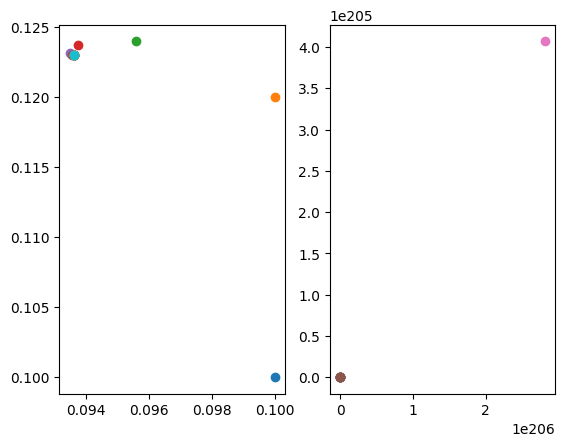

In [28]:
# Two trajectories

z1 = 0
z2 = 0
c1 = 0.1 + 0.1j
c2 = 0.4 + 0.1j

f, ax = plt.subplots(1, 2)

for _ in range(20):
    z1 = mandel(z1, c1)
    z2 = mandel(z2, c2)
    ax[0].scatter(np.real(z1), np.imag(z1))
    ax[1].scatter(np.real(z2), np.imag(z2))

In [15]:
npoints = 1000
maxiter = 1000

In [17]:
re, im = np.linspace(-2, 2, npoints), np.linspace(-2, 2, npoints)
rere, imim = np.meshgrid(re, im)
cc = rere + 1j*imim
zz = np.zeros(cc.shape)

In [18]:
for _ in range(maxiter):
    zz = mandel(zz, cc)

/tmp/ipykernel_9862/2728431307.py:2: RuntimeWarning: overflow encountered in square
  return z**2 + c
/tmp/ipykernel_9862/2728431307.py:2: RuntimeWarning: invalid value encountered in square
  return z**2 + c


In [19]:
zz_abs = np.abs(zz)

In [37]:
re_stable = rere[~np.isnan(zz_abs)]
im_stable = imim[~np.isnan(zz_abs)]

In [38]:
re0, im0 = np.mean(re_stable), np.mean(im_stable)
max_re = np.max(re_stable)   
min_re = np.min(re_stable) 
max_im = np.max(im_stable)   
min_im = np.min(im_stable) 

In [41]:
rad_stable = np.sqrt((re_stable-re0)**2 + (im_stable-im0)**2)
max_rad = np.max(rad_stable)

p_per_unit_area = npoints**2 / (re.max() - re.min()) / (im.max() - im.min())
rad_area = np.pi*max_rad**2 * p_per_unit_area
rect_area = (max_im - min_im) * (max_re - min_re)  * p_per_unit_area

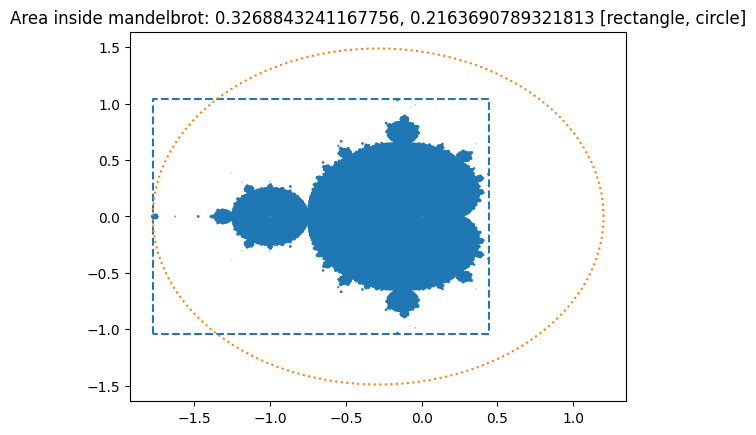

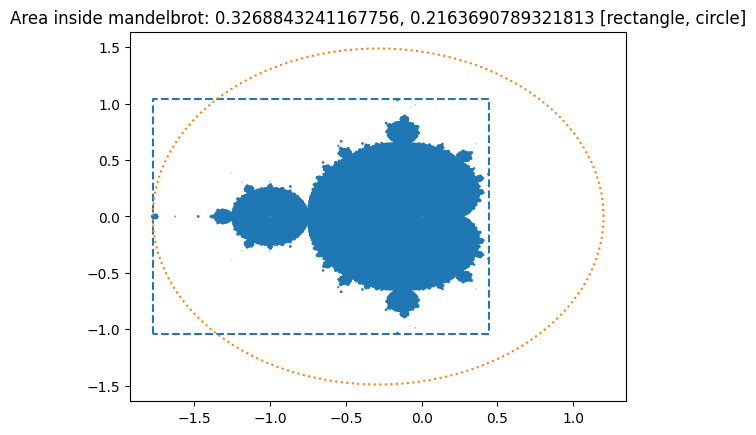

In [46]:
%matplotlib inline

plt.figure()
plt.scatter(rere, imim, zz_abs)

# Simple boundaries
plt.plot([min_re, min_re, max_re, max_re, min_re],
         [min_im, max_im, max_im, min_im, min_im], linestyle='dashed')

angles = np.linspace(0, 2*np.pi, 100)
re_rad, im_rad = re0 + max_rad*np.cos(angles), im0 + max_rad*np.sin(angles)
plt.plot(re_rad, im_rad, linestyle='dotted')

stable_area = re_stable.size
ratio_to_rect = stable_area/rect_area
ratio_to_rad = stable_area/rad_area
plt.title('Area inside mandelbrot: {}, {} [rectangle, circle]'.format(ratio_to_rect,
                                                                      ratio_to_rad))
plt.show()

 # Recursive zoom routine

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
def mandel(z, c):
    return z**2 + c

In [9]:
class Mandel:
    def __init__(self, npoints=100, maxiter=100, re_range=None, im_range=None, z0=0):
        self._npoints = npoints
        self._maxiter = maxiter
        self._re_range = re_range or (-2, 2)
        self._im_range = im_range or (-2, 2)
        self._re, self._im = (np.linspace(*self._re_range, self._npoints, endpoint=True),
                              np.linspace(*self._im_range, self._npoints, endpoint=True))
        self._rere, self._imim = np.meshgrid(self._re, self._im)
        self._cc = self._rere + 1j*self._imim
        self._zz = z0*np.ones(self._cc.shape)
        self._iter = np.zeros(self._cc.shape)
        self.p_per_unit_area = self._npoints**2 / (self._re.max() - self._re.min()) / (self._im.max() - self._im.min())

        self.post = {}
        
    def run(self):
        for _ in range(self._maxiter):
            self._zz = mandel(self._zz, self._cc)
            self._iter += ~np.isnan(self._zz)
            
    def analyse(self):
        zz_abs = np.abs(self._zz)
        re_stable = self._rere[~np.isnan(zz_abs)]
        im_stable = self._imim[~np.isnan(zz_abs)]
        re0, im0 = np.mean(re_stable), np.mean(im_stable)

        max_re = np.max(re_stable)
        min_re = np.min(re_stable)
        max_im = np.max(im_stable)
        min_im = np.min(im_stable)
        
        rad_stable = np.sqrt((re_stable-re0)**2 + (im_stable-im0)**2)
        max_rad = np.max(rad_stable)
        
        rad_area = np.pi*max_rad**2 * self.p_per_unit_area
        rect_area = (max_im - min_im) * (max_re - min_re)  * self.p_per_unit_area
        
        self.post['zz_abs'] = zz_abs
        self.post['re_stable'] = re_stable
        self.post['im_stable'] = im_stable
        self.post['re0'] = re0
        self.post['im0']= im0
        self.post['max_re'] = max_re
        self.post['min_re'] = min_re
        self.post['max_im'] = max_im
        self.post['min_im'] = min_im
        self.post['rad_stable'] = rad_stable
        self.post['max_rad'] = max_rad
        self.post['rad_area'] = rad_area
        self.post['rect_area'] = rect_area
        
            
    def plot(self, axis=None):
        if axis is None:
            fig, axis = plt.subplots()
            
        axis.scatter(self.post['re_stable'], self.post['im_stable'], marker='.', s=1)
        
        # Simple boundaries
        axis.plot([self.post['min_re'], self.post['min_re'], self.post['max_re'], self.post['max_re'], self.post['min_re']],
                 [self.post['min_im'], self.post['max_im'], self.post['max_im'], self.post['min_im'], self.post['min_im']],
                 linestyle='dashed')
        
        angles = np.linspace(0, 2*np.pi, 100)
        re_rad, im_rad = (self.post['re0'] + self.post['max_rad']*np.cos(angles),
                          self.post['im0'] + self.post['max_rad']*np.sin(angles))
        axis.plot(re_rad, im_rad, linestyle='dotted')
        
        stable_area = self.post['re_stable'].size
        ratio_to_rect = stable_area/self.post['rect_area']
        ratio_to_rad = stable_area/self.post['rad_area']
        axis.set_title('Area inside mandelbrot: {}, {} [rectangle, circle]'.format(ratio_to_rect,
                                                                              ratio_to_rad))
        return axis


/tmp/ipykernel_24524/2728431307.py:2: RuntimeWarning: overflow encountered in square
  return z**2 + c
/tmp/ipykernel_24524/2728431307.py:2: RuntimeWarning: invalid value encountered in square
  return z**2 + c


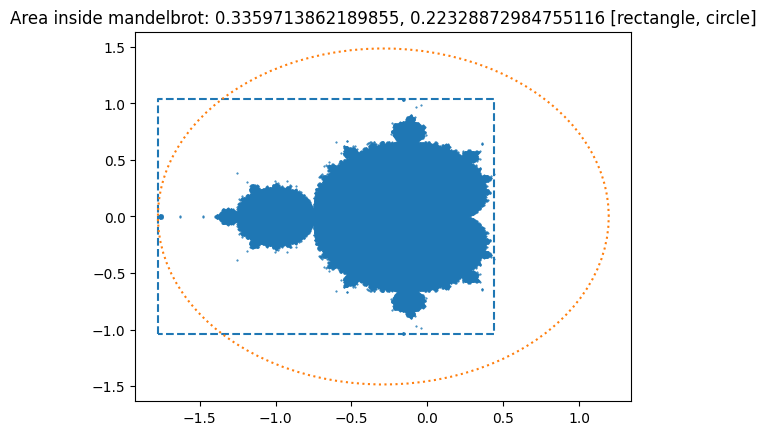

In [11]:
mb = Mandel(npoints=1000)
mb.run()
mb.analyse()
mb.plot();

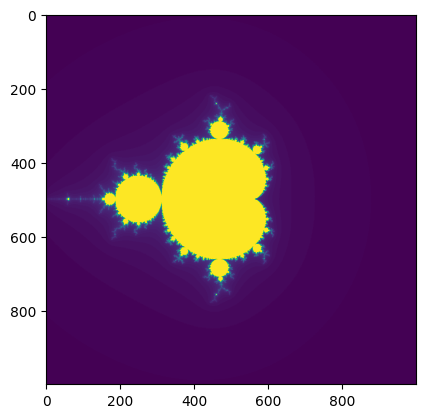

In [12]:
plt.imshow(mb._iter)

## Side note: what ratio do the areas of Mandelbrot vs. circle/rectangle approach?

In [13]:
rect_areas, rad_areas = [], []
npointss = [10, 50, 100, 500, 1000, 5000, 10000]
for npoints in npointss:
    mb = Mandel(npoints=npoints)
    mb.run()
    mb.analyse()
    rect_areas.append(mb.post['re_stable'].size/mb.post['rect_area'])
    rad_areas.append(mb.post['re_stable'].size/mb.post['rad_area'])

/tmp/ipykernel_11674/2728431307.py:2: RuntimeWarning: overflow encountered in square
  return z**2 + c
/tmp/ipykernel_11674/2728431307.py:2: RuntimeWarning: invalid value encountered in square
  return z**2 + c
/tmp/ipykernel_11674/1443431906.py:19: RuntimeWarning: overflow encountered in absolute
  zz_abs = np.abs(self._zz)


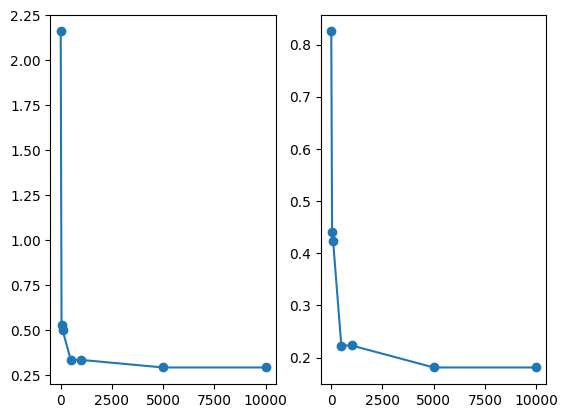

In [14]:
f, ax = plt.subplots(1, 2)
ax[0].plot(npointss, rect_areas, marker='o')
ax[1].plot(npointss, rad_areas, marker='o')


## end sidenote

/tmp/ipykernel_24524/2728431307.py:2: RuntimeWarning: overflow encountered in square
  return z**2 + c
/tmp/ipykernel_24524/2728431307.py:2: RuntimeWarning: invalid value encountered in square
  return z**2 + c


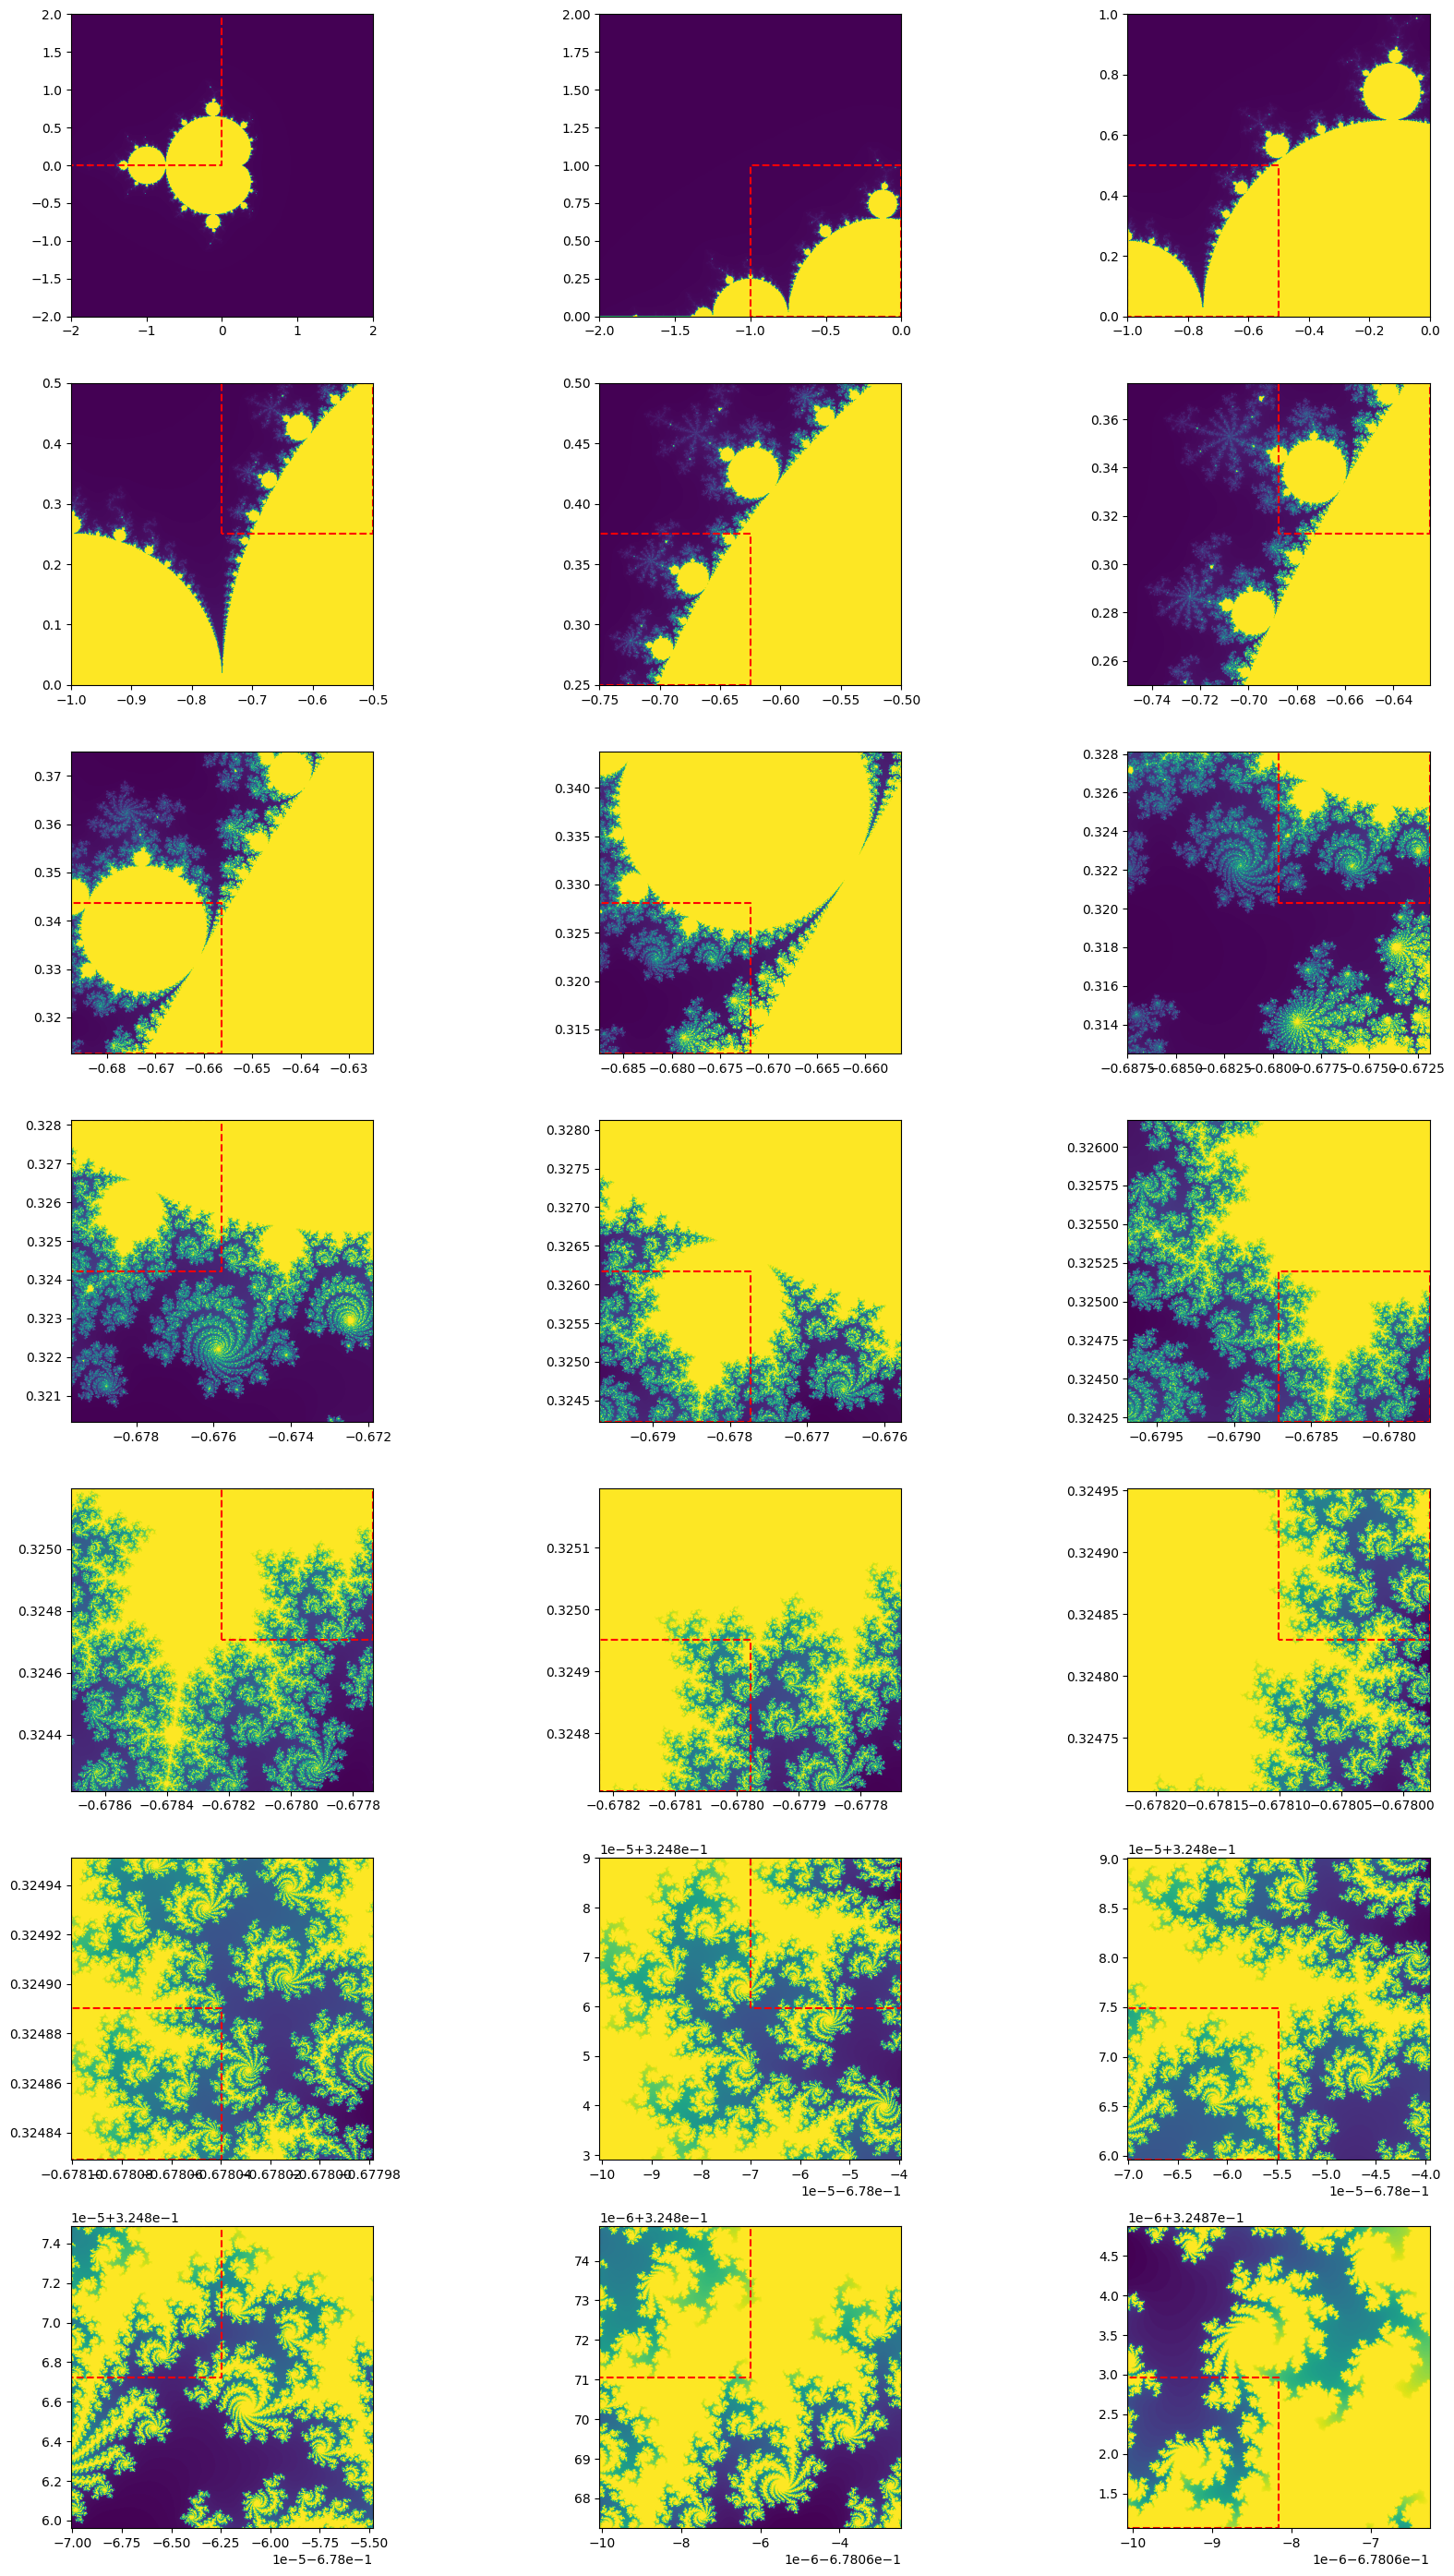

In [29]:
from math import ceil

nsectors = 3 # Will split the plot in (n-1) x (n-1) grid
ndepths = 21 # Will perform the zoom n times
npoints = 500 # Will grid-up the plane with n x n points
maxiter = 500 # Will apply the map n times
z0 = 0

f, ax = plt.subplots(ceil(ndepths/3), 3, figsize=(3*6, ceil(ndepths/3)*4))
ax = ax.flatten()

mb = Mandel(npoints=npoints, maxiter=maxiter, z0=z0)

for axis, _ in zip(ax, range(ndepths)):
    mb.run()
    mb.analyse()
    axis.imshow(mb._iter, extent=[mb._re.min(), mb._re.max(), mb._im.max(), mb._im.min()])
    
    resectors = np.linspace(*mb._re_range, nsectors, endpoint=True)
    imsectors = np.linspace(*mb._im_range, nsectors, endpoint=True)
    stable_ratios = []
    re_idxs = []
    im_idxs = []
    
    for i, (resec0, resec1) in enumerate(zip(resectors[:-1], resectors[1:])):
        for j, (imsec0, imsec1) in enumerate(zip(imsectors[:-1], imsectors[1:])):
            zz_tmp = mb.post['zz_abs'][(mb._rere >= resec0) & (mb._rere < resec1) &
                                    (mb._imim >= imsec0) & (mb._imim < imsec1)]
            
            if zz_tmp.size == 0:
                stable_ratio = 0
            else:
                stable_ratio = np.sum(np.isnan(zz_tmp))/zz_tmp.size
                
            stable_ratios.append(stable_ratio)
            re_idxs.append(i)
            im_idxs.append(j)
    
    best_idx = np.argmin(np.abs(np.array(stable_ratios)-0.5))
    best_re = re_idxs[best_idx]
    best_im = im_idxs[best_idx]
    new_rerange = (resectors[best_re], resectors[best_re+1])
    new_imrange = (imsectors[best_im], imsectors[best_im+1])
    
    axis.plot(
        [new_rerange[0], new_rerange[0], new_rerange[1], new_rerange[1], new_rerange[0]],
        [new_imrange[0], new_imrange[1], new_imrange[1], new_imrange[0], new_imrange[0]],
        linestyle='dashed', color='red',
    )
    
    axis.set_xlim(mb._re_range)
    axis.set_ylim(mb._im_range)
    
    mb = Mandel(npoints=npoints, maxiter=maxiter,
                re_range=new_rerange,im_range=new_imrange,
                z0=z0)
    
f.tight_layout()